In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os

In [2]:
saveFigures = False

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [44]:
def plot_learningCurve(train_sizes, train_scores, valid_scores):
    '''
    quick macro for plotting learning curves
    returns plt object for titling?
    '''

    fig, ax = plt.subplots()

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.legend(loc="best")

    return fig, ax

# Build Model: Young's Modulus

Import feature set, import data

In [4]:
base_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [5]:
with gzip.open('./datasets/youngs_features.pkl.gz', 'rb') as fp:
    X_E = pkl.load(fp)
with gzip.open('./datasets/youngs_data.pkl.gz', 'rb') as fd:
    youngsData = pkl.load(fd)

In [7]:
with gzip.open('./datasets/youngsSmall_features.pkl.gz', 'rb') as fp:
    X_Esmall = pkl.load(fp)
with gzip.open('./datasets/youngsSmall_data.pkl.gz', 'rb') as fd:
    youngsDataSmall = pkl.load(fd)

EOFError: Ran out of input

In [8]:
print(np.where(np.isnan(X_E)))
featCleanImpute(X_E)
print(np.where(np.isnan(X_E)))

(array([  4,   8,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69, 164,
       174, 237, 237, 729, 745], dtype=int64), array([145, 145,  48,  49,  50,  51,  52,  53, 143, 144, 145, 146, 145,
       145, 145, 146, 145, 145], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [9]:
youngs_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [10]:
# Look at feature importances when trained on the whole data set
youngs_model.fit(X_E, y=youngsData['E'])

Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [11]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

# Generate learning curves, assess quality of model

In [12]:
train_sizes, train_scores, valid_scores = learning_curve(youngs_model, X_E, youngsData['E'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

C:\Users\Hikaru\Anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



figure saved


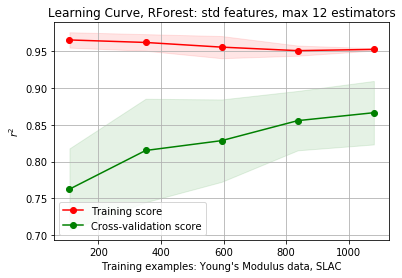

In [91]:
fig, ax = plot_learningCurve(train_sizes, train_scores, valid_scores)
ax.set_title('Learning Curve, RForest: std features, max 12 estimators')
ax.set_xlabel("Training examples: Young's Modulus data, SLAC")
ax.set_ylabel("$r^2$")
if saveFigures:
    print('figure saved')
    fig.savefig(os.path.join(os.getcwd(),'results','learningCurve-Youngs_StdModel.png'))

In [24]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
featTop5 = pd.DataFrame()

kf = KFold(5)
rep=0
youngsData['E_predict'] = np.nan
for train_index, test_index in kf.split(youngsData['comp']):
    print('Split #{}'.format(rep))
    youngs_model.fit(X_E[train_index,:], youngsData['E'][train_index])
    
    y_youngsPredict = youngs_model.predict(X_E[test_index,:])
    youngsData['E_predict'][test_index] = y_youngsPredict
    
    featureImp = pd.DataFrame(youngs_model.steps[1][1].feature_importances_,
                          index=base_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    featTop5 = featTop5.append(featureImp)
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

featTop5['totalImp'] = featTop5.groupby(level=0)['importance'].transform('sum')
featTop5 = featTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
featTop5.head()
featTop5.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_youngsDefault.csv'))

Split #0
                        importance
mean Electronegativity    0.080824
avg_dev GSbandgap         0.056903
mode GSvolume_pa          0.049333
mean MeltingT             0.035276
minimum GSvolume_pa       0.034042
Split #1
                        importance
mean GSvolume_pa          0.066807
minimum CovalentRadius    0.049451
maximum MeltingT          0.046033
mean GSmagmom             0.038211
minimum GSvolume_pa       0.037463
Split #2
                        importance
minimum GSvolume_pa       0.066103
mean GSvolume_pa          0.059182
maximum MeltingT          0.058807
mean MeltingT             0.056826
minimum CovalentRadius    0.052207
Split #3
                        importance
mean GSvolume_pa          0.076830
minimum CovalentRadius    0.054535
mean MeltingT             0.044403
minimum GSvolume_pa       0.038602
mean Electronegativity    0.036914
Split #4
                        importance
minimum CovalentRadius    0.058466
mean MeltingT             0.055893
mean GSvol

figure saved


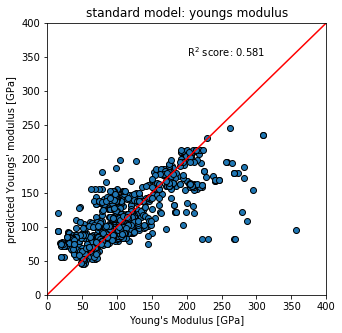

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(youngsData['E'], youngsData['E_predict'], edgecolors='k')
plt.plot([0,400], [0,400], 'r-')
plt.xlabel('Young\'s Modulus [GPa]')
plt.ylabel('predicted Youngs\' modulus [GPa]')

r2Std = r2_score(youngsData['E'], youngsData['E_predict'])
plt.text(200,350, 'R$^2$ score: {:.3f}'.format(r2Std))
plt.xlim([0,400])
plt.ylim([0,400])

plt.title('standard model: youngs modulus')

if saveFigures:
    print('figure saved')
    plt.savefig(os.path.join(os.getcwd(),'results','youngsScatter_StdModel.png'))

In [90]:
featTop5.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_youngsStd.csv'))

# Examine outliers

In [53]:
youngsData['E_diff'] = youngsData['E_predict'] - youngsData['E']

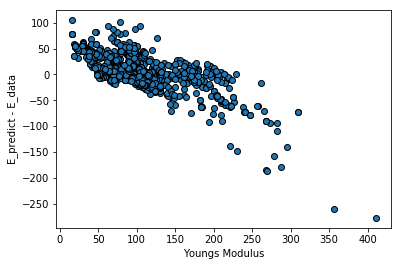

In [89]:
plt.scatter(youngsData['E'],youngsData['E_diff'], edgecolors='k')
plt.xlabel('Youngs Modulus')
plt.ylabel('E_predict - E_data')
plt.savefig(os.path.join(os.getcwd(), 'results', 'youngs_errorScatter.png'))

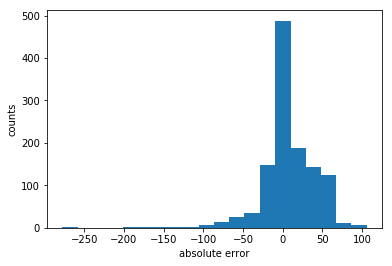

In [88]:
diffHist, bins = np.histogram(youngsData['E_diff'], bins=20, density=False)
plt.bar(bins[:-1], diffHist, width=20, align='edge')
plt.xlabel('absolute error')
plt.ylabel('counts')
plt.savefig(os.path.join(os.getcwd(), 'results', 'youngs_errorHistogram.png'))